# 이원산분석
- melt 형태의 표를 만들어주고 처리

In [1]:
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm 
import seaborn as sb
from math import sqrt
from hossam import load_data
from scipy.stats import t, normaltest, bartlett, levene, f_oneway, ttest_ind
from statsmodels.stats.anova import anova_lm 
from pingouin import anova, welch_anova
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.formula.api import ols
from pandas import DataFrame, melt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell

In [2]:
my_dpi = 200
font_path = 'C:\\Users\\wodyd\\Documents\\카카오톡 받은 파일./MaruBuri-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = 'MaruBuri'
my_theme = 'dark'
sb.set_theme(style = my_theme)

plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [3]:
origin = load_data('sunlight_watering_growth')
origin.head()
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
origin.info()

[data] https://data.hossam.kr/data/lab10_/sunlight_watering_growth.xlsx
[desc] 식물의 씨앗을 심고 햇빛 노출과 물 주기를 다른 조건으로 하여 두 달 동안 자라게 한 후 각 식물의 높이를 인치 단위로 기록한 데이터 (출처: 방송통신대학교 통계학개론)

field    description
-------  ----------------------------------------------------------------
water    각 식물에 물을 주는 빈도 (매일:`daily`, 매주: `weekly`)
sun      각 식물이 받은 햇빛 노출량 (낮음:`low`, 중간:`med`, 높음:`high`)
height   2개월 후 각 식물의 높이 (인치)

데이터셋 크기: (120, 3)
열 개수: 3
행 개수: 120
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   water   120 non-null    object 
 1   sun     120 non-null    object 
 2   height  120 non-null    float64
dtypes: float64(1), object(2)
memory usage: 2.9+ KB


## 시각화
### 관수빈도별 햇빛 노출 빈도에 따른 식물 높이 비교

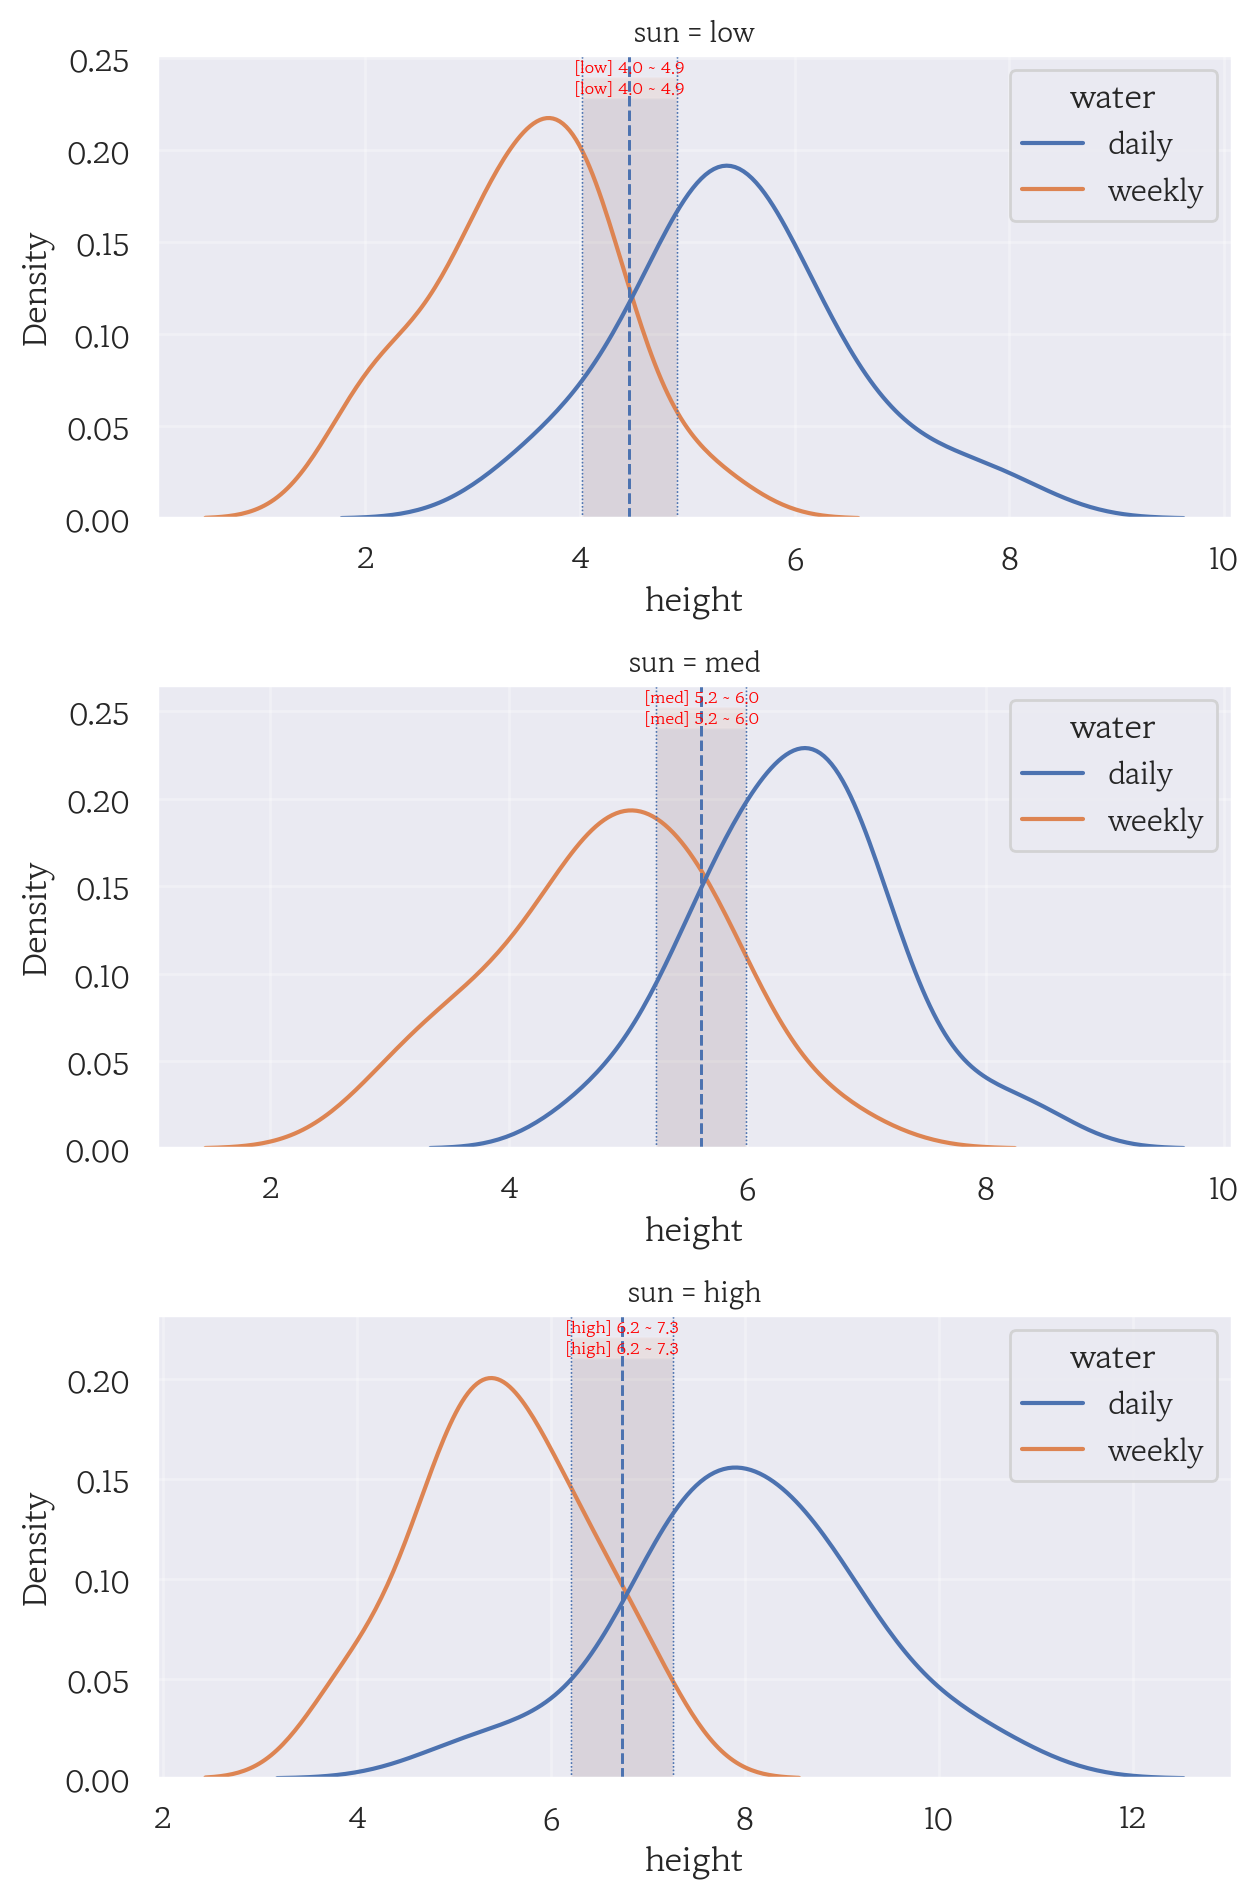

In [4]:
# 확인할 데이터 필드
field = 'height'

# 집단을 구분하는 필드
hue_field = 'water'

group_field = 'sun'

# 값 종류 구하기 + 시각화 할 필드
data = origin[[field, group_field, hue_field]]
group_values = origin[group_field].unique()
group_count = len(group_values)
hue_values = data[hue_field].unique()

# 1) 그래프 초기화
rows = group_count # 그래프 행 수
cols = 1 # 그래프 열 수
width_px = 1280 * cols # 그래프 가로 크기
height_px = 640 * rows # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

for i, v in enumerate(group_values):
 temp = data[data[group_field] == v]
 sb.kdeplot(data = temp, x=field, hue = hue_field, ax =ax[i])
 ax[i].grid(True, alpha=0.3) # 배경 격자 표시/숨김
 ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize = 10, pad = 5)

 for h in hue_values:
  temp_sub = temp[temp[hue_field] == h]
# 신뢰구간
  max = temp[field].max() # 최대값
  clevel = 0.95 # 신뢰수준
  dof = len(temp[field]) - 1 # 자유도
  sp_mean = temp[field].mean() # 표본평균
  sp_std = temp[field].std(ddof=1) # 표본표준편차
  sp_std_error = sp_std / sqrt(len(temp[field])) # 표본표준오차
  cmin, cmax = t.interval(clevel, dof, loc=sp_mean, 
              scale=sp_std_error)
  ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
  ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

# 평균 표시
  ymin, ymax = ax[i].get_ylim()
  ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
  ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

# 텍스트 그리기
  ax[i].text(x=(cmax-cmin)/2+cmin,
          y=ymax,
          s="[%s] %0.1f ~ %0.1f" % (v, cmin, cmax),
          horizontalalignment="center",
          verticalalignment="bottom",
          fontdict={"size": 6, "color": "red"})

# 4) 출력
plt.tight_layout() # 여백 제거
plt.show() # 그래프 화면 출력
plt.close() # 그래프 작업 종료

### 햇빛 노출 빈도별 관수량에 따른 식물 높이 비교

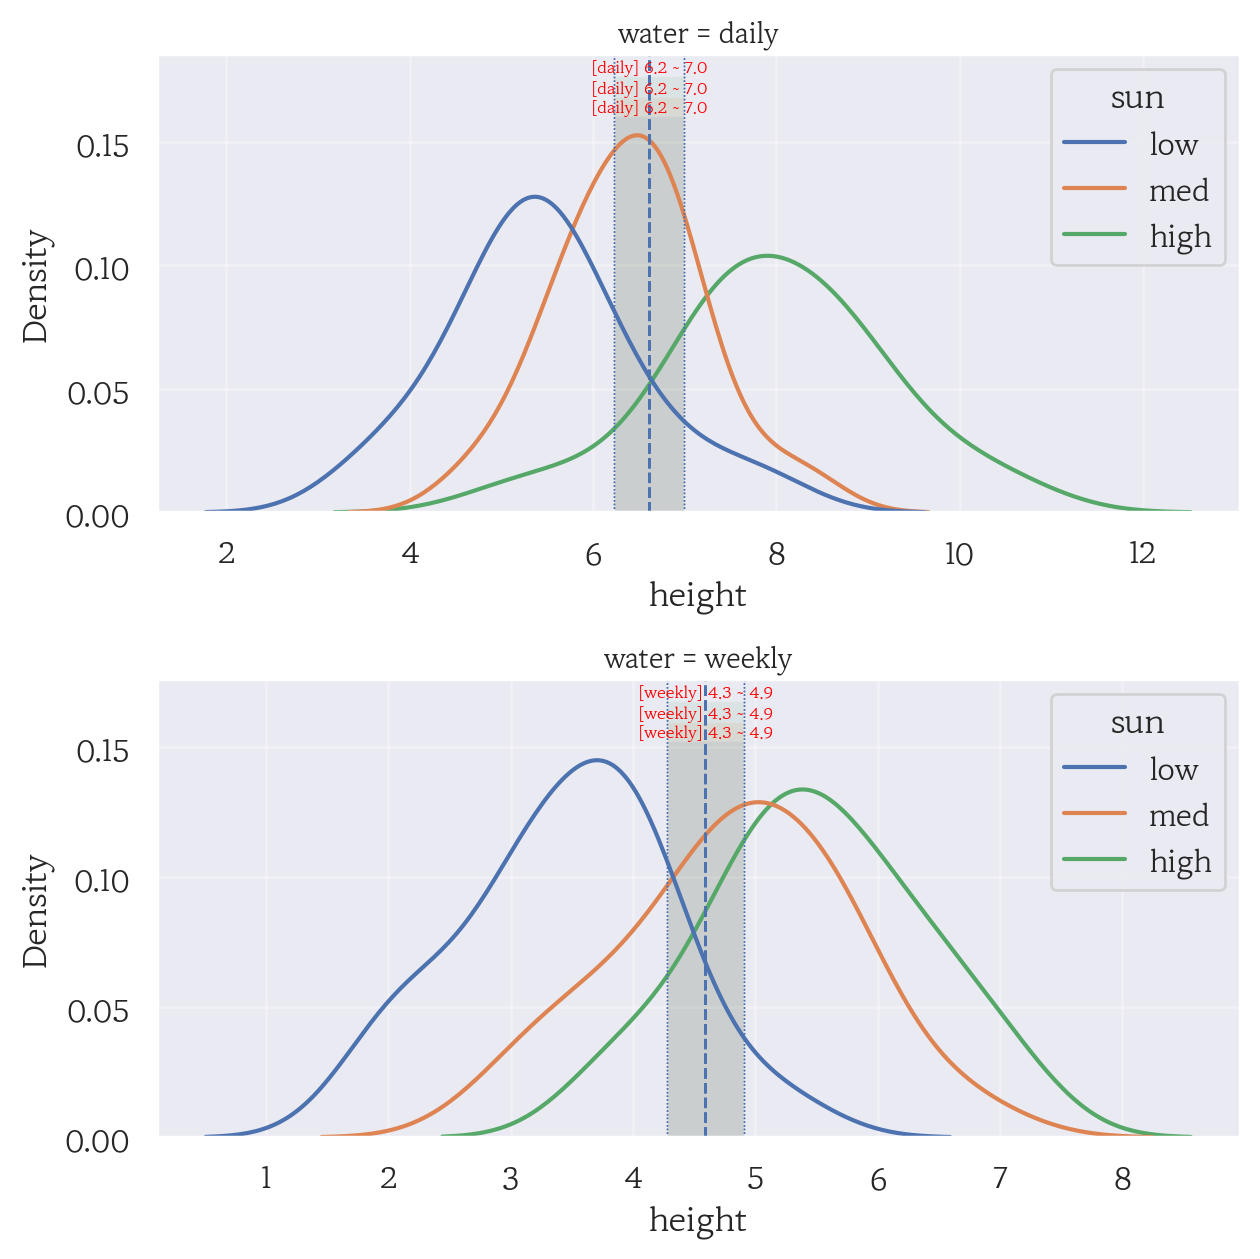

In [5]:
# 확인할 데이터 필드
field = 'height'

# 집단을 구분하는 필드
hue_field = 'sun'

group_field = 'water'

# 값 종류 구하기 + 시각화 할 필드
data = origin[[field, group_field, hue_field]]
group_values = origin[group_field].unique()
group_count = len(group_values)
hue_values = data[hue_field].unique()

# 1) 그래프 초기화
rows = group_count # 그래프 행 수
cols = 1 # 그래프 열 수
width_px = 1280 * cols # 그래프 가로 크기
height_px = 640 * rows # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

for i, v in enumerate(group_values):
 temp = data[data[group_field] == v]
 sb.kdeplot(data = temp, x=field, hue = hue_field, ax =ax[i])
 ax[i].grid(True, alpha=0.3) # 배경 격자 표시/숨김
 ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize = 10, pad = 5)

 for h in hue_values:
  temp_sub = temp[temp[hue_field] == h]
# 신뢰구간
  max = temp_sub[field].max() # 최대값
  clevel = 0.95 # 신뢰수준
  dof = len(temp[field]) - 1 # 자유도
  sp_mean = temp[field].mean() # 표본평균
  sp_std = temp[field].std(ddof=1) # 표본표준편차
  sp_std_error = sp_std / sqrt(len(temp[field])) # 표본표준오차
  cmin, cmax = t.interval(clevel, dof, loc=sp_mean, 
              scale=sp_std_error)
  ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
  ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

# 평균 표시
  ymin, ymax = ax[i].get_ylim()
  ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
  ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

# 텍스트 그리기
  ax[i].text(x=(cmax-cmin)/2+cmin,
          y=ymax,
          s="[%s] %0.1f ~ %0.1f" % (v, cmin, cmax),
          horizontalalignment="center",
          verticalalignment="bottom",
          fontdict={"size": 6, "color": "red"})

# 4) 출력
plt.tight_layout() # 여백 제거
plt.show() # 그래프 화면 출력
plt.close() # 그래프 작업 종료

### 분산분석의 가정 확인

In [6]:
data = origin.copy()
xname = ['water', 'sun']
yname = 'height'

u1 = data[xname[0]].unique()
u2 = data[xname[1]].unique()
equal_var_fields = []
normal_dist = True
report = []

for i in u1:
 for j in u2:
  filtered_data = data[(data[xname[0]] == i) & (data[xname[1]] == j)][yname]
  equal_var_fields.append(filtered_data)
  s, p = normaltest(filtered_data)
  normalize = p > 0.05
  report.append({'field':'{0}, {1}'.format(i, j), 'statistic': s, 'p-value': p, 'result': normalize})
  normal_dist = normal_dist and normalize

# 등분산성 검정 선택
if normal_dist:
 n = "Bartlett"
 s, p = bartlett(*equal_var_fields)
else:
 n = "Levene"
 s, p = levene(*equal_var_fields)

equal_var = p> 0.05
report.append({'field': n, 'statistic': s, 'p-value': p, 'result': p > 0.05})

report_df = DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
"daily, low",1.461514,0.481544,True
"daily, med",0.866582,0.648372,True
"daily, high",0.801917,0.669678,True
"weekly, low",0.073958,0.963697,True
"weekly, med",0.160764,0.922764,True
"weekly, high",0.052520,0.974082,True
Bartlett,4.488400,0.481437,True


## 이원분산분석
### 분산분석 결과 생성

In [7]:
xname = ['water', 'sun']
yname = 'height'

pg_anova = anova(data = origin, dv = yname, between = xname)
pg_anova

,Source,SS,DF,MS,F,p-unc,np2
0,water,122.816333,1,122.816333,130.528994,1.301312e-20,0.533798
1,sun,103.292167,2,51.646083,54.889371,2.013276e-17,0.490568
2,water * sun,4.327167,2,2.163583,2.299453,1.049489e-01,0.038777
3,Residual,107.264000,114,0.940912,NaN,NaN,NaN


### 결과 문장 생성



In [8]:
for idx in pg_anova.index:
    row = pg_anova.iloc[idx]
    source = row['Source']
    p_val = row['p-unc']

    if p_val <= 0.05:
        print(f' -> {source} 효과는 유의함. (대립가설 채택: p <= 0.05)')
    else:
        print(f' -> {source} 효과는 유의하지 않음. (귀무가설 채택: p <= 0.05)')    

 -> water 효과는 유의함. (대립가설 채택: p <= 0.05)
 -> sun 효과는 유의함. (대립가설 채택: p <= 0.05)
 -> water * sun 효과는 유의하지 않음. (귀무가설 채택: p <= 0.05)
 -> Residual 효과는 유의하지 않음. (귀무가설 채택: p <= 0.05)


## 사후검정

In [9]:
xname = ['water', 'sun']
yname = 'height'
data = origin[xname + [yname]]
levels = {} # 빈 딕셔너리 만들기

# 예: {'water': 2, 'sun': 3} 이런 식 결과
for factor in xname: # 요인을 하나씩 꺼냄
 level_count = data[factor].nunique() # 요인의 수준 수 계산
 levels[factor] = level_count # 딕셔너리에 저장

pvals = {} # 빈 딕셔너리 만들기

# 예: {'water': 1.30e-20, 'sun': 2.01e-17, 'water * sun': 0.105}
for index, row in pg_anova.iterrows(): # 행을 하나씩 꺼냄
    source_name = row['Source'] # 요인 이름
    p_value = row['p-unc'] # 각 요인의 p-value
    pvals[source_name] = p_value # 딕셔너리에 저장
for factor in xname:
    print(f"\n[{factor}]")
    if levels[factor] == 2:
        print(f"- {levels[factor]}수준 요인이므로 사후검정이 필요 없습니다.")
        continue
    
    p_val = pvals.get(factor, None)
    if p_val is None:
        print("- ANOVA 결과에서 해당 요인을 찾을 수 없습니다.")
        continue
    if p_val > 0.05:
        print(f"- 주효과 유의하지 않음 (p={p_val:.3g}) → 사후검정 수행 안 함")
        continue

    print(f"- 주효과 유의 (p={p_val:.3g}) → 사후검정 수행")

    if equal_var:
        print(" · Tukey HSD 사용 (등분산 충족)")
        hoc_df = pairwise_tukey(data=data, dv=yname, between=factor)
    else:
        print(" · Games–Howell 사용 (등분산 불충족)")
        hoc_df = pairwise_gameshowell(data=data, dv=yname, 
        between=factor)#03. 인사이트
        display(hoc_df)

# 상호작용 자동 처리
interaction_names = [src for src in pvals.keys() if '*' in src]

for inter in interaction_names:
    p_val = pvals[inter]
    print(f"\n[{inter}] 상호작용 효과")
    if p_val == 0.05:
        print(f"- 상호작용 유의 (p={p_val:.3g}) → 단순주효과 분석 필요")
    else:
        print(f"- 상호작용 유의하지 않음 (p={p_val:.3g}) → 단순주효과 분석 필요 없음")


[water]
- 2수준 요인이므로 사후검정이 필요 없습니다.

[sun]
- 주효과 유의 (p=2.01e-17) → 사후검정 수행
 · Tukey HSD 사용 (등분산 충족)

[water * sun] 상호작용 효과
- 상호작용 유의하지 않음 (p=0.105) → 단순주효과 분석 필요 없음


## 인사이트

### 요인별 유의성 판단

- {요인1}: F = {F값}, p = {p값}, ηp² = {효과크기} → {유의성 판단}
- {요인2}: F = {F값}, p = {p값}, ηp² = {효과크기} → {유의성 판단}
- {상호작용}: F = {F값}, p = {p값}, ηp² = {효과크기} → {유의성 판단}
(**요약:**) {핵심 요약문 1–2문장}

### 기술통계 및 집단별 평균 비교

- {요인1} 수준별 평균: …
- {요인2} 수준별 평균: …
- 상호작용 조합 평균(해당 시): …
(**요약 해석:**) {패턴 설명}

### 사후검정(post-hoc)

- {요인1}: {수준 수}수준 → {사후검정 여부 및 이유}
- {요인2}: {사후검정 결과 요약}
- 상호작용(simple effects): {필요 여부}
(**요약 해석:**) {사후검정으로 확인된 구체적 차이}

### 최종 결론 요약

- • {핵심 인사이트 1}
- • {핵심 인사이트 2}
- • {핵심 인사이트 3}
- • {모형의 의미 있는 해석}
(**최종 한 문장 결론:**) {DV}는 {주요 요인}의 영향을 크게 받으며, {상호작용 여부}가 확인되었다.

## 측정자에 따른 태아의 머리 둘레 측정 비교

In [10]:
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm 
import seaborn as sb
from math import sqrt
from hossam import load_data
from scipy.stats import t, normaltest, bartlett, levene, f_oneway, ttest_ind
from statsmodels.stats.anova import anova_lm 
from pingouin import anova, welch_anova
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.formula.api import ols
from pandas import DataFrame, melt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell

In [11]:
my_dpi = 200
font_path = 'C:\\Users\\wodyd\\Documents\\카카오톡 받은 파일./MaruBuri-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = 'MaruBuri'
my_theme = 'dark'
sb.set_theme(style = my_theme)

plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [12]:
origin = load_data('head_size')
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab10_/head_size.xlsx
[desc] 3명의 태아를 대상으로 3명의 관측자가 측정한 태아의 머리 둘레 자료 (출처: 방송통신대학교 통계학 개론)
[!] Cannot read metadata
데이터셋 크기: (60, 4)
열 개수: 4
행 개수: 60
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   측정자번호   60 non-null     int64  
 1   1번태아    60 non-null     float64
 2   2번태아    60 non-null     float64
 3   3번태아    60 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 2.0 KB
None


,측정자번호,1번태아,2번태아,3번태아
0,1,14.9,19.7,13.0
1,1,14.4,20.7,13.5
2,1,14.4,19.9,13.2
3,1,15.1,20.2,12.8
4,1,15.4,19.4,13.8


In [13]:
df = melt(origin, id_vars = '측정자번호', value_vars = ['1번태아', '2번태아', '3번태아'], var_name = '태아번호', value_name ='머리둘레')
df.head()

,측정자번호,태아번호,머리둘레
0,1,1번태아,14.9
1,1,1번태아,14.4
2,1,1번태아,14.4
3,1,1번태아,15.1
4,1,1번태아,15.4


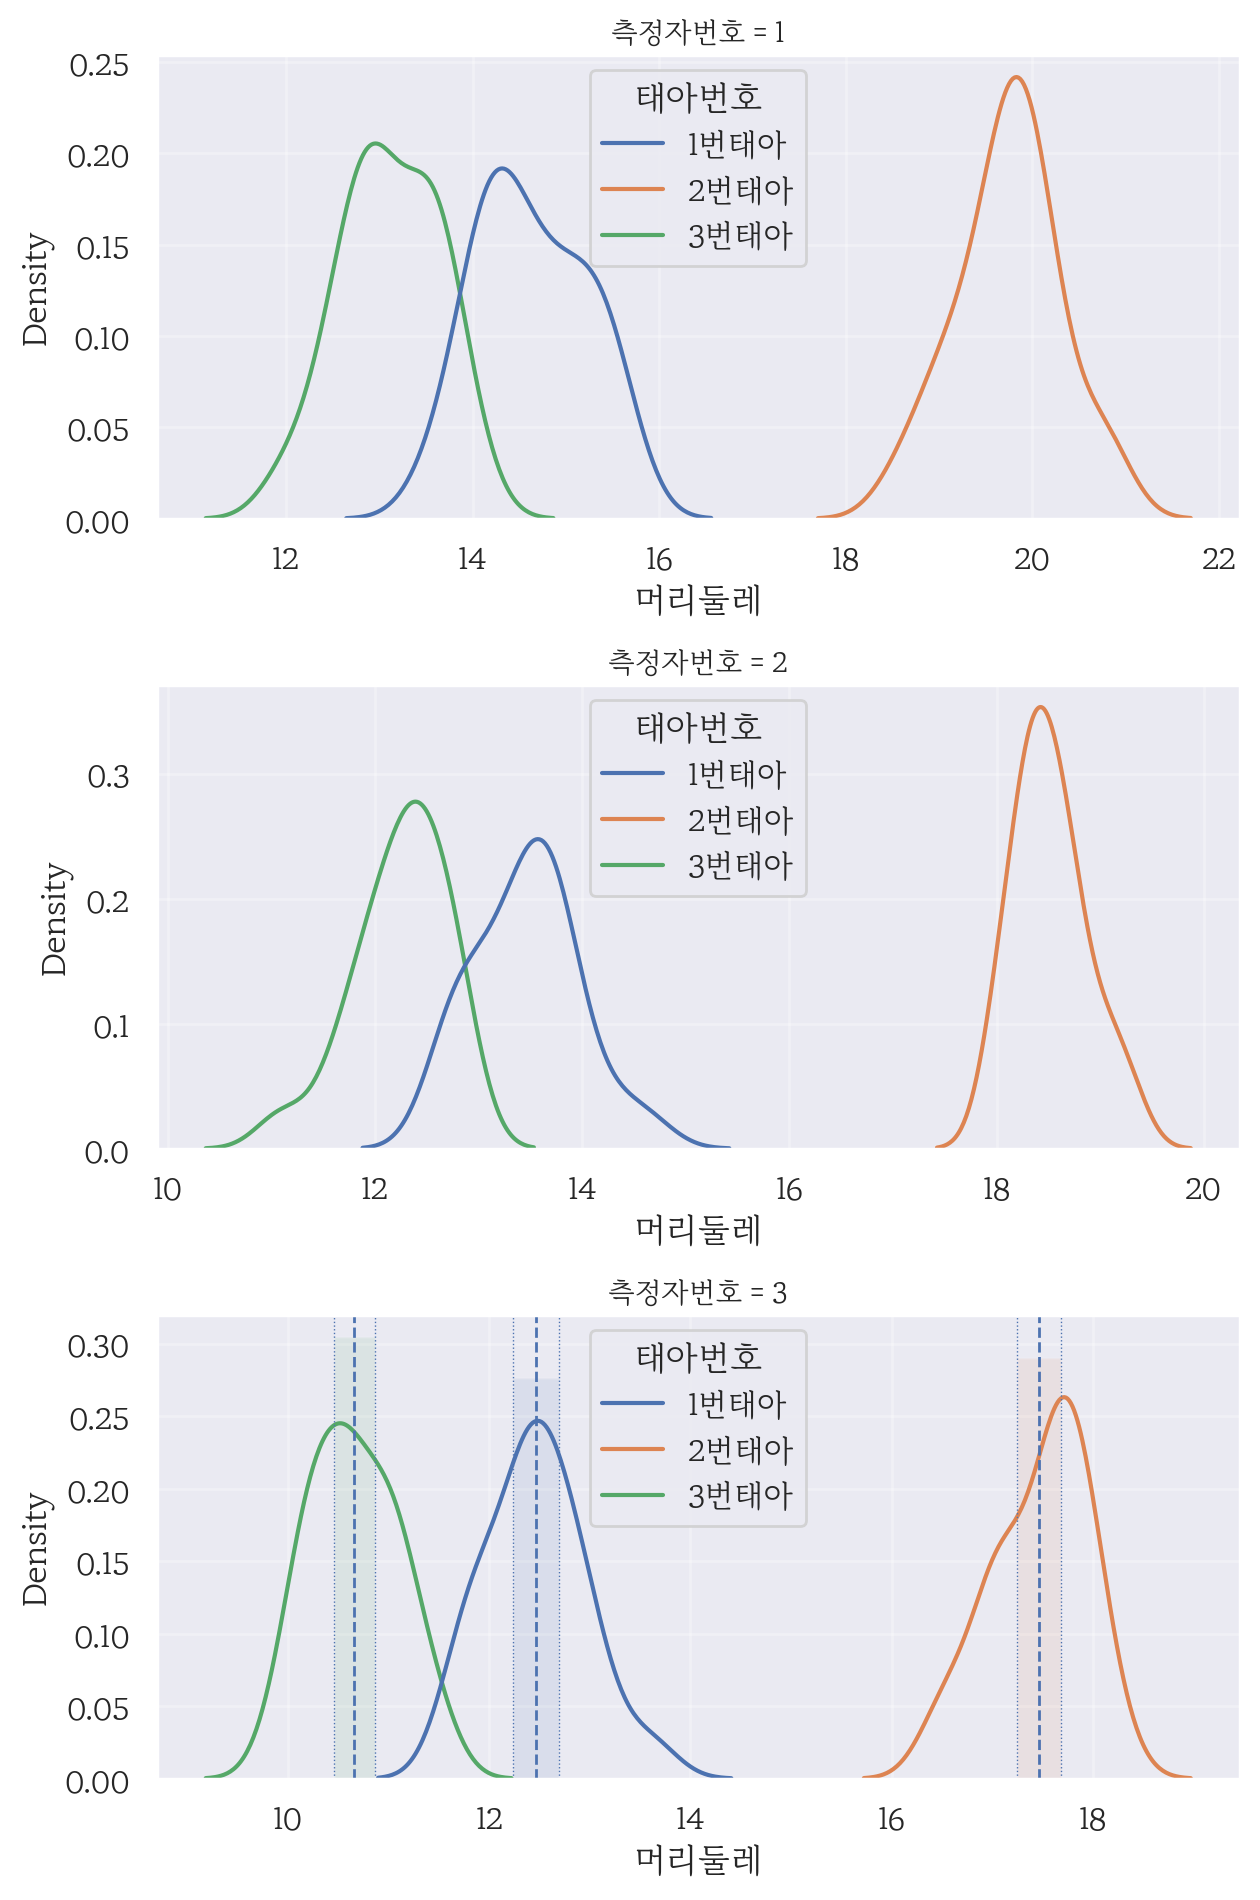

In [14]:
field = '머리둘레'
group_field = '측정자번호'
hue_field = '태아번호'
# 시각화 할 필드만 원본 데이터에서 추출
data = df[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)
hue_values = data[hue_field].unique()
# 1) 그래프 초기화
rows = group_count # 그래프 행 수
cols = 1 # 그래프 열 수
width_px = 1280 * cols # 그래프 가로 크기
height_px = 640 * rows # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)
# ax 객체가 행,열 수에 따라서 리스트가 된다.
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
# 2) 그래프 그리기
for i, v in enumerate(group_values):
 temp = data[data[group_field] == v]
 sb.kdeplot(data=temp, x=field, hue=hue_field, ax=ax[i])
 ax[i].grid(True, alpha=0.3)
 ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize=10, 
pad=5)
for h in hue_values:
 temp_sub = temp[temp[hue_field] == h]
# 신뢰구간
 max = temp_sub[field].max() # 최대값
 clevel = 0.95 # 신뢰수준
 dof = len(temp_sub[field]) - 1 # 자유도
 sp_mean = temp_sub[field].mean() # 표본평균
 sp_std = temp_sub[field].std(ddof=1) # 표본표준

 sp_std_error = sp_std / sqrt(len(temp_sub[field])) # 표본표준
 cmin, cmax = t.interval(clevel, dof, loc=sp_mean, 
    scale=sp_std_error)
 ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
 ax[i].axvline(cmax, linestyle=':', linewidth=0.5)
# 평균 표시
 ymin, ymax = ax[i].get_ylim()
 ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
 ax[i].axvline(sp_mean, linestyle='--', linewidth=1)
# 텍스트 그리기 ax[i].text(x=(cmax-cmin)/2+cmin,
 y=ymax,
 s="[%s] %0.1f ~ %0.1f" % (h, cmin, cmax),
 horizontalalignment="center",
 verticalalignment="bottom",
 fontdict={"size": 6, "color": "red"}
# 4) 출력
plt.tight_layout() # 여백 제거
plt.show() # 그래프 화면 출력
plt.close() # 그래프 작업 종료

In [15]:
data = df.copy()
xname = ['측정자번호', '태아번호']
yname = '머리둘레'

u1 = data[xname[0]].unique()
u2 = data[xname[1]].unique()
equal_var_fields = []
normal_dist = True
report = []

for i in u1:
 for j in u2:
  filtered_data = data[(data[xname[0]] == i) & (data[xname[1]] == j)][yname]
  equal_var_fields.append(filtered_data)
  s, p = normaltest(filtered_data)
  normalize = p > 0.05
  report.append({'field':'{0}, {1}'.format(i, j), 'statistic': s, 'p-value': p, 'result': normalize})
  normal_dist = normal_dist and normalize

# 등분산성 검정 선택
if normal_dist:
 n = "Bartlett"
 s, p = bartlett(*equal_var_fields)
else:
 n = "Levene"
 s, p = levene(*equal_var_fields)

equal_var = p> 0.05
report.append({'field': n, 'statistic': s, 'p-value': p, 'result': p > 0.05})

report_df = DataFrame(report).set_index('field')
report_df 

,statistic,p-value,result
field,,,
"1, 1번태아",1.885153,0.389623,True
"1, 2번태아",0.290183,0.864943,True
"1, 3번태아",0.408716,0.815171,True
"2, 1번태아",0.454973,0.796533,True
"2, 2번태아",1.442948,0.486035,True
"2, 3번태아",3.862339,0.144979,True
"3, 1번태아",0.666927,0.716438,True
"3, 2번태아",1.463170,0.481146,True
"3, 3번태아",0.846989,0.654755,True


## 분산분석 수행

In [16]:
xname = ['측정자번호', '태아번호']
yname = '머리둘레'
data = df[xname + [yname]]

 # 등분산 충족하지 않는 경우

if equal_var:
     pg_anova = anova(data = data, dv = yname, between = xname)
else:
     pg_anova = welch_anova(data = data, dv = yname, between = xname)
display(pg_anova)

for idx in pg_anova.index:
    row = pg_anova.iloc[idx]
    source = row['Source']
    p_val = row['p-unc']

    if p_val <= 0.05:
        print(f' -> {source} 효과는 유의함. (대립가설 채택: p <= 0.05)')
    else:
        print(f' -> {source} 효과는 유의하지 않음. (귀무가설 채택: p <= 0.05)')   

,Source,SS,DF,MS,F,p-unc,np2
0,측정자번호,159.320778,2,79.660389,336.822068,4.904107e-60,0.797548
1,태아번호,1422.825444,2,711.412722,3008.013241,5.616407e-134,0.972362
2,측정자번호 * 태아번호,2.201222,4,0.550306,2.326816,5.827850e-02,0.051619
3,Residual,40.442500,171,0.236506,NaN,NaN,NaN


 -> 측정자번호 효과는 유의함. (대립가설 채택: p <= 0.05)
 -> 태아번호 효과는 유의함. (대립가설 채택: p <= 0.05)
 -> 측정자번호 * 태아번호 효과는 유의하지 않음. (귀무가설 채택: p <= 0.05)
 -> Residual 효과는 유의하지 않음. (귀무가설 채택: p <= 0.05)


## 사후검정

In [17]:
xname = ['측정자번호', '태아번호']
yname = '머리둘레'
data = data[xname + [yname]]
levels = {} # 빈 딕셔너리 만들기

# 예: {'water': 2, 'sun': 3} 이런 식 결과
for factor in xname: # 요인을 하나씩 꺼냄
 level_count = data[factor].nunique() # 요인의 수준 수 계산
 levels[factor] = level_count # 딕셔너리에 저장

pvals = {} # 빈 딕셔너리 만들기

# 예: {'water': 1.30e-20, 'sun': 2.01e-17, 'water * sun': 0.105}
for index, row in pg_anova.iterrows(): # 행을 하나씩 꺼냄
    source_name = row['Source'] # 요인 이름
    p_value = row['p-unc'] # 각 요인의 p-value
    pvals[source_name] = p_value # 딕셔너리에 저장
for factor in xname:
    print(f"\n[{factor}]")
    if levels[factor] == 2:
        print(f"- {levels[factor]}수준 요인이므로 사후검정이 필요 없습니다.")
        continue
    
    p_val = pvals.get(factor, None)
    if p_val is None:
        print("- ANOVA 결과에서 해당 요인을 찾을 수 없습니다.")
        continue
    if p_val > 0.05:
        print(f"- 주효과 유의하지 않음 (p={p_val:.3g}) → 사후검정 수행 안 함")
        continue

    print(f"- 주효과 유의 (p={p_val:.3g}) → 사후검정 수행")

    if equal_var:
        print(" · Tukey HSD 사용 (등분산 충족)")
        hoc_df = pairwise_tukey(data=data, dv=yname, between=factor)
    else:
        print(" · Games–Howell 사용 (등분산 불충족)")
        hoc_df = pairwise_gameshowell(data=data, dv=yname, 
        between=factor)#03. 인사이트
        display(hoc_df)

# 상호작용 자동 처리
interaction_names = [src for src in pvals.keys() if '*' in src]

for inter in interaction_names:
    p_val = pvals[inter]
    print(f"\n[{inter}] 상호작용 효과")
    if p_val == 0.05:
        print(f"- 상호작용 유의 (p={p_val:.3g}) → 단순주효과 분석 필요")
    else:
        print(f"- 상호작용 유의하지 않음 (p={p_val:.3g}) → 단순주효과 분석 필요 없음")


[측정자번호]
- 주효과 유의 (p=4.9e-60) → 사후검정 수행
 · Tukey HSD 사용 (등분산 충족)

[태아번호]
- 주효과 유의 (p=5.62e-134) → 사후검정 수행
 · Tukey HSD 사용 (등분산 충족)

[측정자번호 * 태아번호] 상호작용 효과
- 상호작용 유의하지 않음 (p=0.0583) → 단순주효과 분석 필요 없음


## 연습문제
### 문제 1

In [1]:
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm 
import seaborn as sb
from math import sqrt
from hossam import load_data
from scipy.stats import t, normaltest, bartlett, levene, f_oneway, ttest_ind
from statsmodels.stats.anova import anova_lm 
from pingouin import anova, welch_anova
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.formula.api import ols
from pandas import DataFrame, melt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell

In [17]:
my_dpi = 200
font_path = 'C:\\Users\\wodyd\\Documents\\카카오톡 받은 파일./MaruBuri-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = 'MaruBuri'
my_theme = 'dark'
sb.set_theme(style = my_theme)

plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [18]:
origin = load_data('poisons')
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/lab10_/poisons.xlsx
[desc] 독극물 종류별로 동물의 생존시간을 기록한 실험 데이터 (출처: 방송통신대학교 통계학 개론)

field    description
-------  ------------------
time     동물의 생존시간
poison   사용된 독극물 종류
treat    사용되는 치료 유형

데이터셋 크기: (360, 3)
열 개수: 3
행 개수: 360
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    360 non-null    float64
 1   poison  360 non-null    object 
 2   treat   360 non-null    object 
dtypes: float64(1), object(2)
memory usage: 8.6+ KB
None


,time,poison,treat
0,3.8,P1,T1
1,2.7,P1,T1
2,1.7,P1,T1
3,2.2,P1,T1
4,0.7,P1,T1


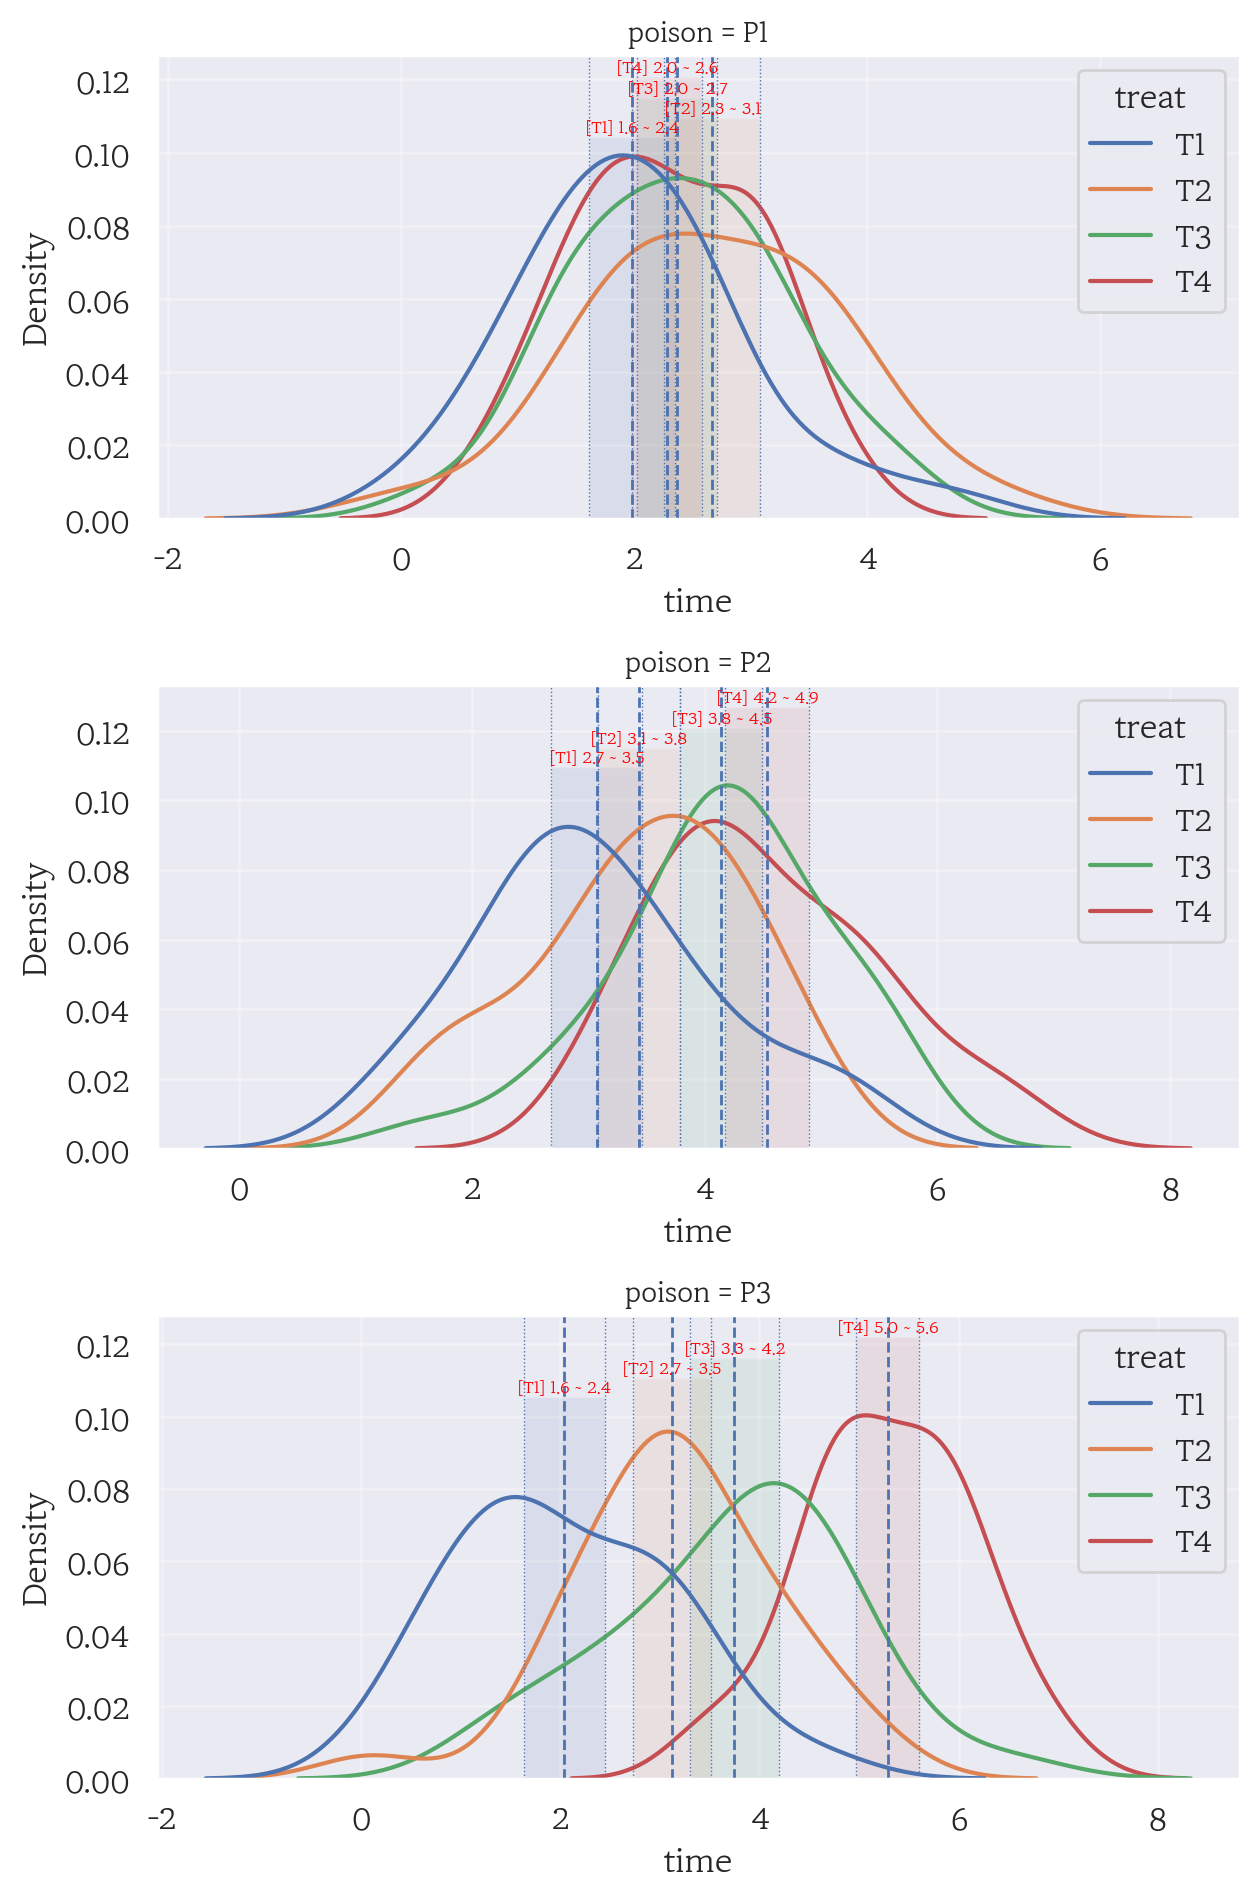

In [ ]:
field = 'time'
group_field = 'poison'
hue_field = 'treat'
# 시각화 할 필드만 원본 데이터에서 추출
data = origin[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)
hue_values = data[hue_field].unique()

# 1) 그래프 초기화
rows = group_count # 그래프 행 수
cols = 1 # 그래프 열 수
width_px = 1280 * cols # 그래프 가로 크기
height_px = 640 * rows # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

# ax 객체가 행,열 수에 따라서 리스트가 된다.

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
# 2) 그래프 그리기
for i, v in enumerate(group_values):
   temp = data[data[group_field] == v]
   sb.kdeplot(data=temp, x=field, hue=hue_field, ax=ax[i])
   ax[i].grid(True, alpha=0.3)
   ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize=10, pad=5)
   for h in hue_values:
      temp_sub = temp[temp[hue_field] == h]
# 신뢰구간
      max = temp_sub[field].max() # 최대값
      clevel = 0.95 # 신뢰수준
      dof = len(temp_sub[field]) - 1 # 자유도
      sp_mean = temp_sub[field].mean() # 표본평균
      sp_std = temp_sub[field].std(ddof=1) # 표본표준

      sp_std_error = sp_std / sqrt(len(temp_sub[field])) # 표본표준
      cmin, cmax = t.interval(clevel, dof, loc=sp_mean, 
      scale=sp_std_error)
      ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
      ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

   # 평균 표시
      ymin, ymax = ax[i].get_ylim()
      ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
      ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

   # 텍스트 그리기 
      ax[i].text(x=(cmax-cmin)/2+cmin,y=ymax,
      s="[%s] %0.1f ~ %0.1f" % (h, cmin, cmax),
      horizontalalignment="center",
      verticalalignment="bottom",
      fontdict={"size": 6, "color": "red"})
# 4) 출력
plt.tight_layout() # 여백 제거
plt.show() # 그래프 화면 출력
plt.close() # 그래프 작업 종료

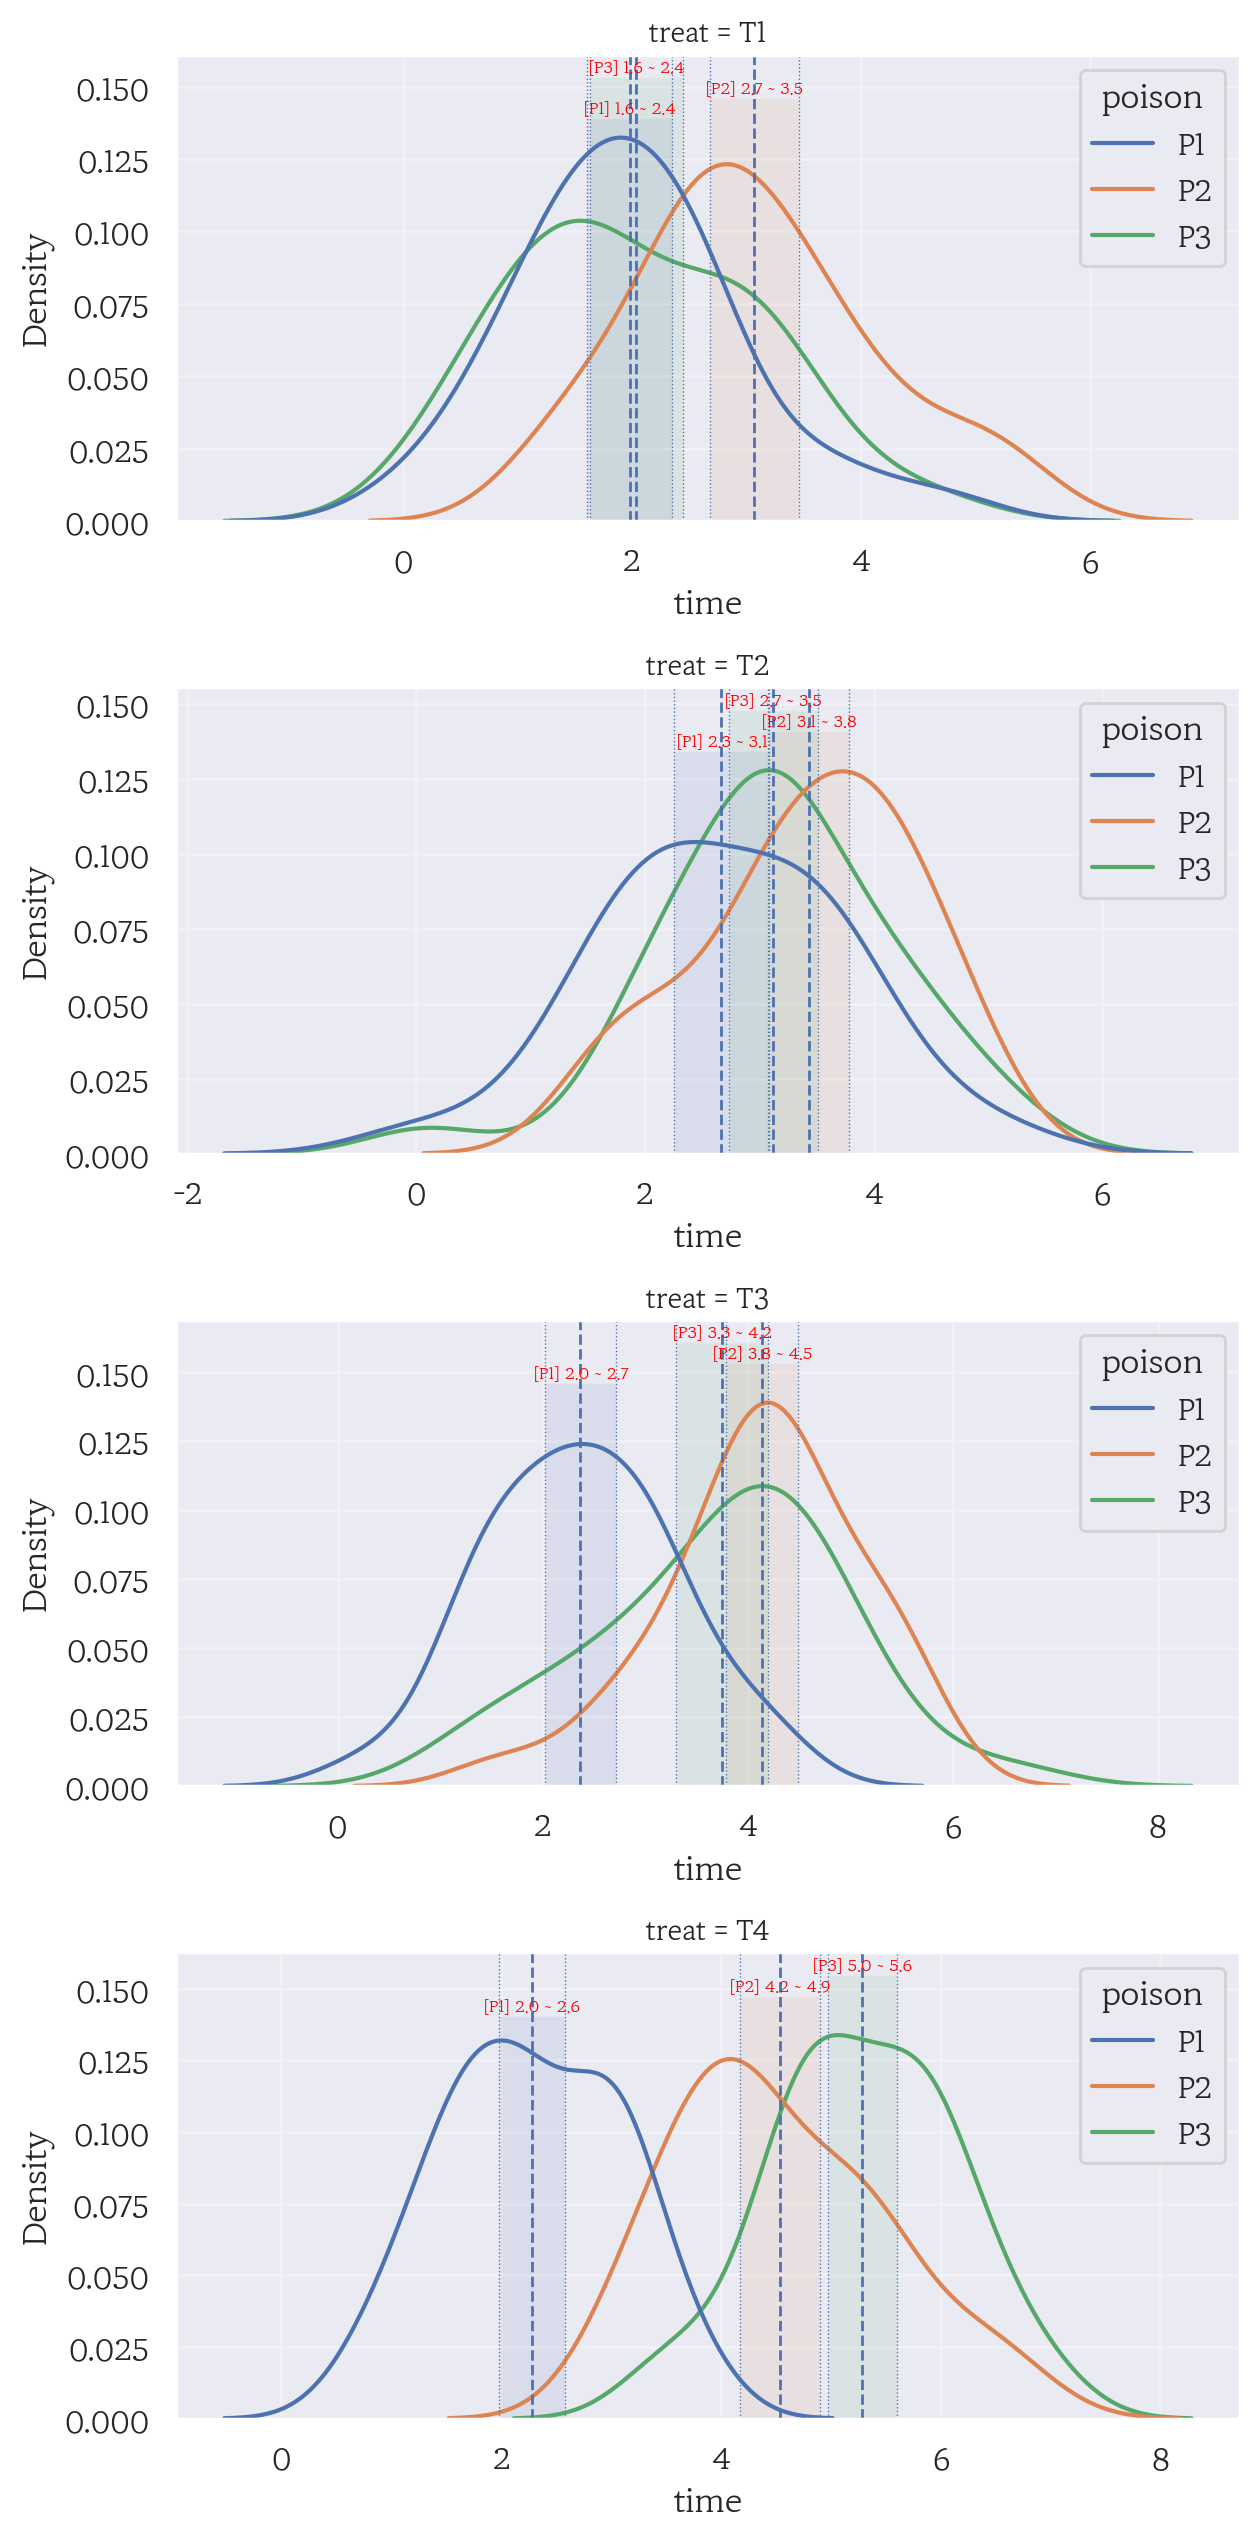

In [6]:
field = 'time'
group_field = 'treat'
hue_field = 'poison'
# 시각화 할 필드만 원본 데이터에서 추출
data = origin[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)
hue_values = data[hue_field].unique()

# 1) 그래프 초기화
rows = group_count # 그래프 행 수
cols = 1 # 그래프 열 수
width_px = 1280 * cols # 그래프 가로 크기
height_px = 640 * rows # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

# ax 객체가 행,열 수에 따라서 리스트가 된다.

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
# 2) 그래프 그리기
for i, v in enumerate(group_values):
   temp = data[data[group_field] == v]
   sb.kdeplot(data=temp, x=field, hue=hue_field, ax=ax[i])
   ax[i].grid(True, alpha=0.3)
   ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize=10, pad=5)
   for h in hue_values:
      temp_sub = temp[temp[hue_field] == h]
# 신뢰구간
      max = temp_sub[field].max() # 최대값
      clevel = 0.95 # 신뢰수준
      dof = len(temp_sub[field]) - 1 # 자유도
      sp_mean = temp_sub[field].mean() # 표본평균
      sp_std = temp_sub[field].std(ddof=1) # 표본표준

      sp_std_error = sp_std / sqrt(len(temp_sub[field])) # 표본표준
      cmin, cmax = t.interval(clevel, dof, loc=sp_mean, 
      scale=sp_std_error)
      ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
      ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

   # 평균 표시
      ymin, ymax = ax[i].get_ylim()
      ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
      ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

   # 텍스트 그리기 
      ax[i].text(x=(cmax-cmin)/2+cmin,y=ymax,
      s="[%s] %0.1f ~ %0.1f" % (h, cmin, cmax),
      horizontalalignment="center",
      verticalalignment="bottom",
      fontdict={"size": 6, "color": "red"})
# 4) 출력
plt.tight_layout() # 여백 제거
plt.show() # 그래프 화면 출력
plt.close() # 그래프 작업 종료

In [ ]:
data = origin.copy()
xname = ['poison', 'treat']
yname = 'time'

u1 = data[xname[0]].unique()
u2 = data[xname[1]].unique()
equal_var_fields = []
normal_dist = True
report = []

for i in u1:
 for j in u2:
  filtered_data = data[(data[xname[0]] == i) & (data[xname[1]] == j)][yname]
  equal_var_fields.append(filtered_data)
  s, p = normaltest(filtered_data)
  normalize = p > 0.05
  report.append({'field':'{0}, {1}'.format(i, j), 'statistic': s, 'p-value': p, 'result': normalize})
  normal_dist = normal_dist and normalize

# 등분산성 검정 선택
if normal_dist:
 n = "Bartlett"
 s, p = bartlett(*equal_var_fields)
else:
 n = "Levene"
 s, p = levene(*equal_var_fields)

equal_var = p> 0.05
report.append({'field': n, 'statistic': s, 'p-value': p, 'result': p > 0.05})

report_df = DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
"P1, T1",3.660816,0.160348,True
"P1, T2",0.266462,0.875263,True
"P1, T3",0.014374,0.992839,True
"P1, T4",1.476194,0.478023,True
"P2, T1",1.112279,0.573418,True
"P2, T2",1.509951,0.470022,True
"P2, T3",2.802084,0.246340,True
"P2, T4",1.662054,0.435602,True
"P3, T1",0.837473,0.657878,True


In [ ]:
xname = ['poison', 'treat']
yname = 'time'
data = origin[xname + [yname]]

 # 등분산 충족하지 않는 경우

if equal_var:
     pg_anova = anova(data = data, dv = yname, between = xname)
else:
     pg_anova = welch_anova(data = data, dv = yname, between = xname)
display(pg_anova)

for idx in pg_anova.index:
    row = pg_anova.iloc[idx]
    source = row['Source']
    p_val = row['p-unc']

    if p_val <= 0.05:
        print(f' -> {source} 효과는 유의함. (대립가설 채택: p <= 0.05)')
    else:
        print(f' -> {source} 효과는 유의하지 않음. (귀무가설 채택: p <= 0.05)')  

,Source,SS,DF,MS,F,p-unc,np2
0,poison,148.976389,2,74.488194,74.722166,1.002877e-27,0.300424
1,treat,131.260972,3,43.753657,43.891090,4.430485e-24,0.274506
2,poison * treat,81.381611,6,13.563602,13.606206,6.938981e-14,0.190014
3,Residual,346.910333,348,0.996869,NaN,NaN,NaN


 -> poison 효과는 유의함. (대립가설 채택: p <= 0.05)
 -> treat 효과는 유의함. (대립가설 채택: p <= 0.05)
 -> poison * treat 효과는 유의함. (대립가설 채택: p <= 0.05)
 -> Residual 효과는 유의하지 않음. (귀무가설 채택: p <= 0.05)


In [26]:
xname = ['poison', 'treat']
yname = 'time'
data = data[xname + [yname]]
levels = {} # 빈 딕셔너리 만들기

# 예: {'water': 2, 'sun': 3} 이런 식 결과
for factor in xname: # 요인을 하나씩 꺼냄
 level_count = data[factor].nunique() # 요인의 수준 수 계산
 levels[factor] = level_count # 딕셔너리에 저장

pvals = {} # 빈 딕셔너리 만들기

# 예: {'water': 1.30e-20, 'sun': 2.01e-17, 'water * sun': 0.105}
for index, row in pg_anova.iterrows(): # 행을 하나씩 꺼냄
    source_name = row['Source'] # 요인 이름
    p_value = row['p-unc'] # 각 요인의 p-value
    pvals[source_name] = p_value # 딕셔너리에 저장

for factor in xname:
    print(f"\n[{factor}]")
    if levels[factor] == 2:
        print(f"- {levels[factor]}수준 요인이므로 사후검정이 필요 없습니다.")
        continue
    
    p_val = pvals.get(factor, None)
    if p_val is None:
        print("- ANOVA 결과에서 해당 요인을 찾을 수 없습니다.")
        continue
    if p_val > 0.05:
        print(f"- 주효과 유의하지 않음 (p={p_val:.3g}) → 사후검정 수행 안 함")
        continue

    print(f"- 주효과 유의 (p={p_val:.3g}) → 사후검정 수행")

    if equal_var:
        print(" · Tukey HSD 사용 (등분산 충족)")
        hoc_df = pairwise_tukey(data=data, dv=yname, between=factor)
    else:
        print(" · Games–Howell 사용 (등분산 불충족)")
        hoc_df = pairwise_gameshowell(data=data, dv=yname, between=factor)
    
    display(hoc_df)

# 상호작용 자동 처리
interaction_names = [src for src in pvals.keys() if '*' in src]

for inter in interaction_names:
    p_val = pvals[inter]
    print(f"\n[{inter}] 상호작용 효과")
    if p_val <= 0.05:
        print(f"- 상호작용 유의 (p={p_val:.3g}) → 단순주효과 분석 필요")
    else:
        print(f"- 상호작용 유의하지 않음 (p={p_val:.3g}) → 단순주효과 분석 필요 없음")


[poison]
- 주효과 유의 (p=1e-27) → 사후검정 수행
 · Tukey HSD 사용 (등분산 충족)


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,P1,P2,2.325000,3.795833,-1.470833,0.161626,-9.100235,5.107026e-14,-1.388884
1,P1,P3,2.325000,3.550000,-1.225000,0.161626,-7.579233,9.585666e-13,-0.931693
2,P2,P3,3.795833,3.550000,0.245833,0.161626,1.521002,2.822579e-01,0.179210



[treat]
- 주효과 유의 (p=4.43e-24) → 사후검정 수행
 · Tukey HSD 사용 (등분산 충족)


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,T1,T2,2.363333,3.075556,-0.712222,0.189827,-3.751957,1.168920e-03,-0.639750
1,T1,T3,2.363333,3.421111,-1.057778,0.189827,-5.572330,2.971230e-07,-0.867932
2,T1,T4,2.363333,4.034444,-1.671111,0.189827,-8.803345,6.006307e-14,-1.220199
3,T2,T3,3.075556,3.421111,-0.345556,0.189827,-1.820373,2.654092e-01,-0.292572
4,T2,T4,3.075556,4.034444,-0.958889,0.189827,-5.051387,4.181336e-06,-0.717648
5,T3,T4,3.421111,4.034444,-0.613333,0.189827,-3.231015,7.343056e-03,-0.430346



[poison * treat] 상호작용 효과
- 상호작용 유의 (p=6.94e-14) → 단순주효과 분석 필요


### 요인별 유의성 판단

- {poison}: F = 43.89, p = 4.43e-24, np^2 = 0.2745 → 유의함(대립가설 채택)
- {treat}:  F = 74.72, p = 1.00e-27, ηp² = 0.3004 → 유의함(대립가설 채택) 
- {poison * treat}:  F = 13.61, p = 6.94e-14, ηp² = 0.1900 → 유의함(대립가설 채택)
(**요약:**) 독성별로, 치료법별로, 두 요인의 조합 모두 생존시간과 상관관계가 있다.
            특정 독성에 대해, 더 효과적인 치료법이 있을 것이다를 시사한다.

### 기술통계 및 집단별 평균 비교
treat 수준별 평균
T1: 2.36
T2: 3.08
T3: 3.42
T4: 4.03
→ 치료 강도가 높아질수록 평균 생존시간이 증가하는 경향.
poison 수준별 평균
P1: 2.33
P2: 3.80
P3: 3.55
→ P1이 가장 독성이 강해 생존시간이 가장 짧고, P2가 상대적으로 가장 길다.

### 사후검정(Post-hoc) 결과
treat: 4수준 + 주효과 유의 → Tukey HSD 수행
주요 차이: 
T1은 T2, T3, T4보다 모두 유의하게 생존시간이 짧음(p < .01)
2 P2 P3 3.795833 3.550000 0.245833 0.161626 1.521002 2.822579e-01 0.179210 
• 
◦ T4는 T2, T3보다도 유의하게 더 김
T2–T3는 유의하지 않음
poison: 3수준 + 주효과 유의 → Tukey HSD 수행
주요 차이: 
P1 < P2 (p < .001)
P1 < P3 (p < .001)
P2–P3는 유의하지 않음
상호작용(simple effects):
상호작용이 유의하므로 조합별 비교가 필요함
치료 유형 간에는 명확한 서열(T4 > T3 ≈ T2 > T1)이 확인되며, 독극물 효과는 P1이 압도적
으로 독성이 강하다.

### 최종 결론 요약
• 치료 유형은 생존시간에 뚜렷한 차이를 만들며, T4가 가장 효과적이고 T1이 가장 낮다.
• 독극물은 생존시간에 강한 영향을 주며, P1이 가장 치명적이다.
• 치료와 독극물 간에는 의미 있는 상호작용이 존재하여, 특정 치료는 특정 독극물에서 특
히 더 효과적이다.
• 사후검정 결과, 대부분의 의미 있는 차이가 치료 서열(T4 > T3 ≈ T2 > T1) 및 독극물
독성(P1 < P3 ≈ P2)을 명확히 보여준다.
(최종 한 문장 결론: 동물의 생존시간은 독극물의 종류와 치료 유형 모두에 강하게 영향을 받으
며, 두 요인의 조합 또한 생존시간 차이를 유의하게 만들어낸다.)

### 문제 2

In [27]:
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm 
import seaborn as sb
from math import sqrt
from hossam import load_data
from scipy.stats import t, normaltest, bartlett, levene, f_oneway, ttest_ind
from statsmodels.stats.anova import anova_lm 
from pingouin import anova, welch_anova
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.formula.api import ols
from pandas import DataFrame, melt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell

In [28]:
my_dpi = 200
font_path = 'C:\\Users\\wodyd\\Documents\\카카오톡 받은 파일./MaruBuri-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = 'MaruBuri'
my_theme = 'dark'
sb.set_theme(style = my_theme)

plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [31]:
origin = load_data('tomato')
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/lab10_/tomato.xlsx
[desc] 효소 성분의 비료가 효소 함량이 증가함에 따라 토마토 모종 포기의 성장에 어떤 영향을 주는지에 대한 실험 결과 (출처: 방송통신대학교 통계학 개론)
[!] Cannot read metadata
데이터셋 크기: (90, 2)
열 개수: 2
행 개수: 90
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   효소함량    90 non-null     int64  
 1   모종성장    90 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.5 KB
None


,효소함량,모종성장
0,0,9.5
1,0,10.0
2,0,10.7
3,0,9.0
4,0,12.4


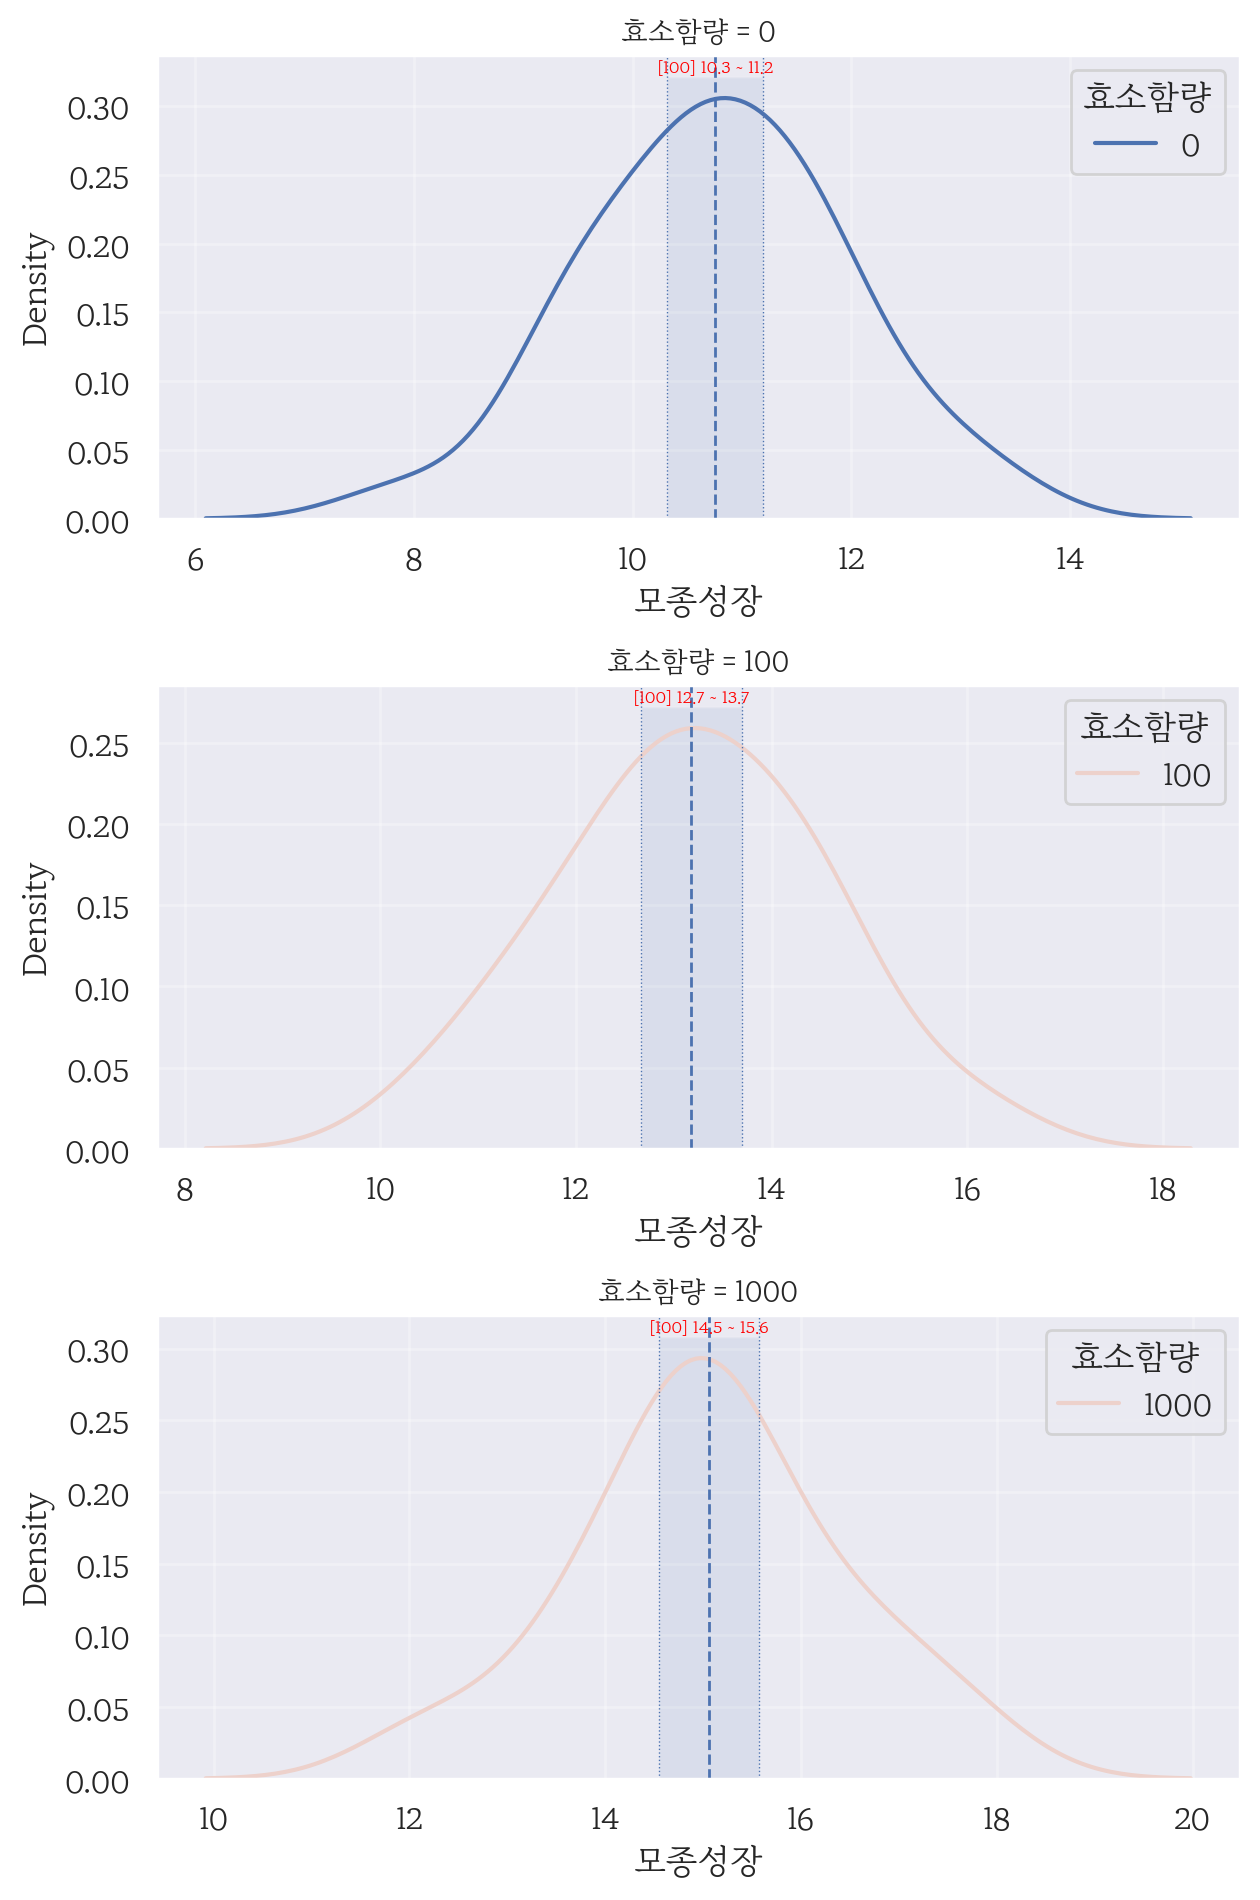

In [36]:
field = '모종성장'
hue_field = '효소함량'
# 시각화 할 필드만 원본 데이터에서 추출
data = origin[[field, hue_field]]

hue_values = data[hue_field].unique()

# 1) 그래프 초기화
rows = 3 # 그래프 행 수
cols = 1 # 그래프 열 수
width_px = 1280 * cols # 그래프 가로 크기
height_px = 640 * rows # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

# ax 객체가 행,열 수에 따라서 리스트가 된다.

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
# 2) 그래프 그리기
for i, v in enumerate(hue_values):
   temp = data[data[hue_field] == v]
   sb.kdeplot(data=temp, x=field, hue=hue_field, ax=ax[i])
   ax[i].grid(True, alpha=0.3)
   ax[i].set_title('{0} = {1}'.format(hue_field, v), fontsize=10, pad=5)
# 신뢰구간
   max = temp[field].max() # 최대값
   clevel = 0.95 # 신뢰수준
   dof = len(temp[field]) - 1 # 자유도
   sp_mean = temp[field].mean() # 표본평균
   sp_std = temp[field].std(ddof=1) # 표본표준
   sp_std_error = sp_std / sqrt(len(temp[field])) # 표본표준
   cmin, cmax = t.interval(clevel, dof, loc=sp_mean, 
   scale=sp_std_error)
   ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
   ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

   # 평균 표시
   ymin, ymax = ax[i].get_ylim()
   ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
   ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

   # 텍스트 그리기 
   ax[i].text(x=(cmax-cmin)/2+cmin,y=ymax,
   s="[%s] %0.1f ~ %0.1f" % (h, cmin, cmax),
   horizontalalignment="center",
   verticalalignment="bottom",
   fontdict={"size": 6, "color": "red"})
# 4) 출력
plt.tight_layout() # 여백 제거
plt.show() # 그래프 화면 출력
plt.close() # 그래프 작업 종료